In [577]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

# 1. Rotação

In [809]:
def rotate(img, ang):
    
    ang = ang*(np.pi/180) #converte de graus para radiano
    r, c = img.shape[0:2] #r = n linhas, c = n colunas
    #desconsidera a linha e a coluna extra adicionadas
    r -= 1
    c -= 1
    #coordenadas do centro da imagem, para rotacionar em volta dele
    ic = r/2
    jc = c/2
    #imagem rotacionada iniciada com zeros. Dimensoes são tais para poder abrigar o maior
    #retangulo rotacionado possível (ang = 45)
    r_rot = int(round(r*np.sqrt(2)))
    c_rot = int(round(c*np.sqrt(2)))
    M_rot = np.zeros((r_rot, c_rot, 3),dtype='uint8')
    #usados para centralizar a imagem rotacionada na imagem de destino, para evitar que 
    #alguns pixels fiquem com indice negativo
    i_cntrlz = int(round((r_rot-r)/2))
    j_cntrlz = int(round((c_rot-c)/2))
    #mapeamento reverso
    M_rev = np.zeros((r,c,3),dtype='uint8')
    M_rot_rev = np.zeros((r_rot, c_rot, 3),dtype='uint8')
    
    for i in range(r):
        for j in range(c):
            ##################### mapeamento direto ########################
            il = int(round((i-ic)*np.cos(-ang) - (j-jc)*np.sin(-ang) + ic))
            jl = int(round((i-ic)*np.sin(-ang) + (j-jc)*np.cos(-ang) + jc))
            #centralizar
            il += i_cntrlz
            jl += j_cntrlz
            #tons de cinza
            M_rot[il,jl,0] = img[i,j,0]
            M_rot[il,jl,1] = M_rot[il,jl,0]
            M_rot[il,jl,2] = M_rot[il,jl,0]
            
            ##################### mapeamento reverso ########################
            il = int(round((i-ic)*np.cos(-ang) - (j-jc)*np.sin(-ang) + ic))
            jl = int(round((i-ic)*np.sin(-ang) + (j-jc)*np.cos(-ang) + jc))
            x = (il-ic)*np.cos(-2*ang) + (jl-jc)*np.sin(-2*ang) + ic
            y = (-1*(il-ic))*np.sin(-2*ang) + (jl-jc)*np.cos(-2*ang) + jc
            #montagem do retangulo para realizar a interpolacao bilinear - coordenadas eixo x
            if x < 0:
                x = 0
            if x<i and x>0:
                ii = i-1
            elif x >= i:
                ii = i
            #montagem do retangulo para realizar a interpolacao bilinear - coordenadas eixo y    
            if y < 0:
                y = 0
            if y < j and y > 0:
                jj = j-1
            elif y >= j:
                jj = j
            #interpolacao bilinear
            i_y = img[ii,jj,0] + (y-jj)*(img[ii,jj+1,0] - img[ii,jj,0])
            i_mais_um_y = img[ii+1,jj,0] + (y-jj)*(img[ii+1,jj+1,0] - img[ii+1,jj,0])
            P = i_y + (x-ii)*(i_mais_um_y-i_y)
            #tons de cinza
            M_rev[i,j,0] = P
            M_rev[i,j,1] = M_rev[i,j,0]
            M_rev[i,j,2] = M_rev[i,j,0]
            ############ rotacao apos mapeamento reverso ##############
            #centralizar
            il += i_cntrlz
            jl += j_cntrlz
            #tons de cinza
            M_rot_rev[il,jl,0] = M_rev[i,j,0]
            M_rot_rev[il,jl,1] = M_rot_rev[il,jl,0]
            M_rot_rev[il,jl,2] = M_rot_rev[il,jl,0]
            
    return M_rot, M_rot_rev, M_rev

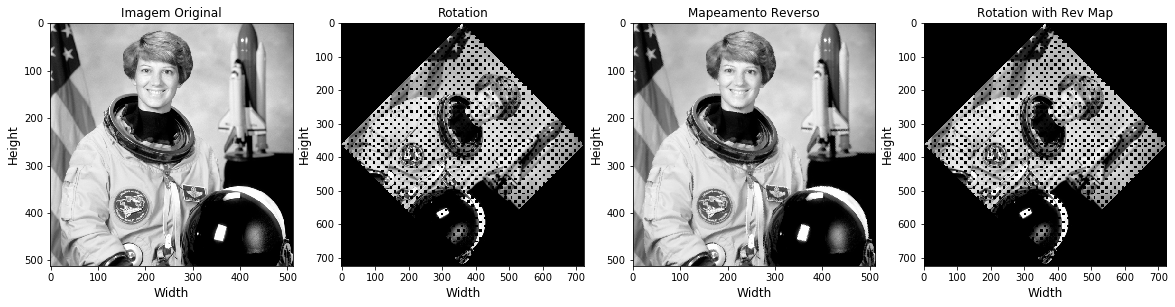

In [810]:
img = io.imread("imageio:astronaut.png")
#tons de cinza
img[:,:,1] = img[:,:,0]
img[:,:,2] = img[:,:,0]

#adiciona uma linha e uma coluna na imagem para auxiliar no mapeamento reverso
img_aux = np.zeros((img.shape[0]+1, img.shape[1]+1, 3))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        for band in range(3):
            img_aux[i,j,band] = img[i,j,0]
        
M_rot, M_rot_rev, M_rev = rotate(img_aux, 45)

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].set_title('Imagem Original', fontsize=12)
ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_xlabel('Width', fontsize=12)
ax[0].imshow(img)

ax[1].set_title('Rotation', fontsize=12)
ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_xlabel('Width', fontsize=12)
ax[1].imshow(M_rot)

ax[2].set_title('Mapeamento Reverso', fontsize=12)
ax[2].set_ylabel('Height', fontsize=12)
ax[2].set_xlabel('Width', fontsize=12)
ax[2].imshow(M_rev)

ax[3].set_title('Rotation with Rev Map', fontsize=12)
ax[3].set_ylabel('Height', fontsize=12)
ax[3].set_xlabel('Width', fontsize=12)
ax[3].imshow(M_rot_rev)